In [91]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


In [3]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

In [4]:
def split(dataset, TRAIN_RATIO = 0.8, VAL_RATIO=0.1, TEST_RATIO=0.1):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
    
    return train_dataset, val_dataset, test_dataset

In [5]:
train_dataset, val_dataset, test_dataset = split(dataset[0])
print(list(train_dataset.take(1).as_numpy_iterator())
      , list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

### Visualization 

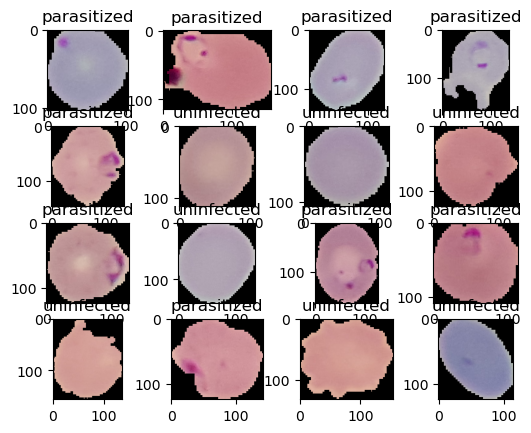

In [6]:
for i, (image,label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))

### Data Processing

In [89]:
IM_SIZE = 224
def resize_rescale(image,label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/ 255.0 , label

In [8]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [9]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
for image, label in train_dataset.take(1):
    print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration  = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration  = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Model Creation

### Sequential API

In [94]:
lenet_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
                             Conv2D(filters =6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Conv2D(filters =16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'sigmoid'),
                             BatchNormalization(),                        
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Flatten(),
    
                             Dense(100, activation = "relu"),
                             BatchNormalization(),
    
                             Dense(10, activation = "relu"),
                             BatchNormalization(),
    
                             Dense(1, activation = "sigmoid"),   

])

lenet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_63 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_64 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

### Functional API

In [59]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters =6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters =16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output =  MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "feature_extractor")
feature_extractor_model.summary()
                                        
                            

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 16)

In [65]:
IM_SIZE - 224
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
    
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),                        
    MaxPool2D(pool_size = 2, strides = 2),
    
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
])

feature_extractor_seq_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_27 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_28 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [66]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")
# x = feature_extractor_model(func_input)
x  = feature_extractor_seq_model(func_input)
x =  Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

output =  Dense(1, activation = "sigmoid")(x)

lenet_model = Model(func_input, output, name = "lenet_model")

lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_6 (Flatten)         (None, 46656)             0         
                                                                 
 dense_18 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_29 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_19 (Dense)            (None, 10)                1010      
                                                       

## Model Subclassing

In [70]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()
        
        self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)
        
        self.conv_2 = Conv2D(filters = filters * 2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D (pool_size = pool_size, strides = 2 * strides)
        
    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)
        
        return x
    
feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

In [72]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")
# x = feature_extractor_model(func_input)
x  = feature_sub_classed(func_input)
x =  Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

output =  Dense(1, activation = "sigmoid")(x)

lenet_model = Model(func_input, output, name = "lenet_model")

lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_1 (Featu  (None, 54, 54, 16)        1488      
 reExtractor)                                                    
                                                                 
 flatten_7 (Flatten)         (None, 46656)             0         
                                                                 
 dense_21 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_33 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_22 (Dense)            (None, 10)                

## Model Class

In [83]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        
        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)
        
        self.flatten = Flatten()
        
        self.dense_1 = Dense(100, activation = "relu")
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(1, activation = "sigmoid")
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation = "sigmoid")
        
    def call(self, x, training):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)

        
        return x
    
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))

lenet_sub_classed.summary()




Model: "lenet_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_5 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_11 (Flatten)        multiple                  0         
                                                                 
 dense_33 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_49 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_34 (Dense)            multiple                  101       
                                                                 
 batch_normalization_50 (Ba  multiple                

## Custom dense layer

In [118]:
class DenseLayer(Layer):
    def __init__(self, output_units, activation):
        super(DenseLayer, self).__init__()
        self.output_units = output_units
        self.activation = activation
        
    def build(self, input_feature_shape):
        self.w = self.add_weight(shape = (input_feature_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
        self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)
        
        def call(self, input_features):
            if self.activation == "relu":
                return tf.nn.relu(tf.matmul(input_features, self.w) + self.b)
            elif self.activation == "sigmoid":
                return tf.math.sigmoid(tf.matmul(input_features, self.w) + self.b)
            else:
                return tf.matmul(input_features, self.w) + self.b

In [119]:
lenet_custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    
                             Conv2D(filters =6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Conv2D(filters =16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'sigmoid'),
                             BatchNormalization(),                        
                             MaxPool2D(pool_size = 2, strides = 2),
    
                             Flatten(),
    
                             DenseLayer(100, activation = "relu"),
                             BatchNormalization(),
    
                             DenseLayer(10, activation = "relu"),
                             BatchNormalization(),
    
                             DenseLayer(1, activation = "sigmoid"),   

])

lenet_custom_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_115 (B  (None, 222, 222, 6)       24        
 atchNormalization)                                              
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_116 (B  (None, 109, 109, 16)      64        
 atchNormalization)                                              
                                                     

### Model Training

In [120]:
lenet_custom_model.compile(optimizer = Adam(learning_rate = 0.01),
             loss = BinaryCrossentropy(),
             metrics = 'accuracy'
             )
                #metrics = RootMeanSquaredError()

In [121]:
history = lenet_custom_model.fit(train_dataset, validation_data = val_dataset,  epochs = 2, verbose = 1)

Epoch 1/2


689/689 [==============================] - 88s 128ms/step - loss: 1.2858 - accuracy: 0.0000e+00 - val_loss: 4.8496 - val_accuracy: 0.0000e+00
Epoch 2/2
689/689 [==============================] - 86s 125ms/step - loss: 0.7894 - accuracy: 0.0000e+00 - val_loss: 6.8000 - val_accuracy: 0.0000e+00


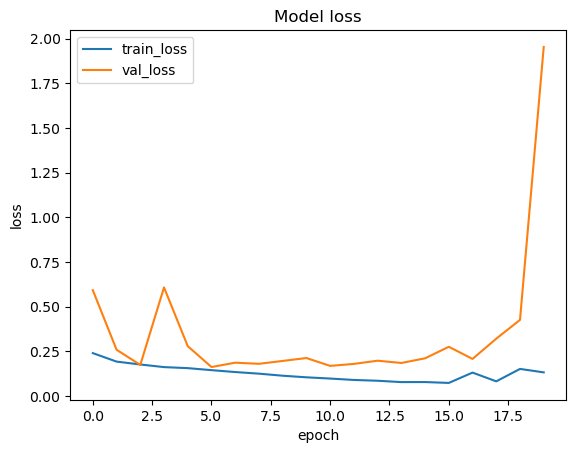

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

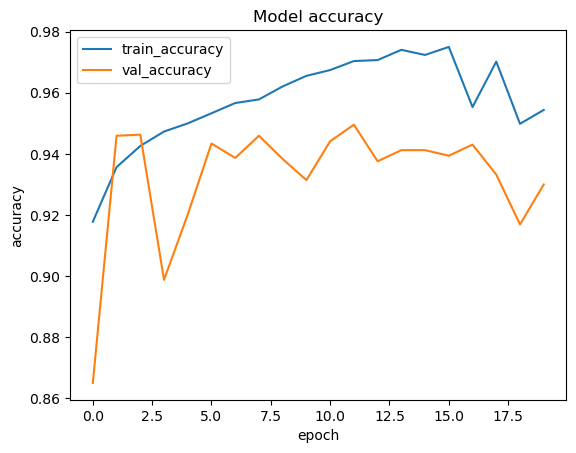

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Model Evaluation and Testing

In [36]:
test_dataset = test_dataset.batch(1)

In [37]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 10s 3ms/step - loss: 1.8064 - accuracy: 0.9249


[1.8063976764678955, 0.9249184131622314]

In [47]:
def parasite_or_not(x):
    if(x < 0.5):
        return str('P')
    else:
        return str('U')

In [46]:
parasite_or_not(lenet_model.predict(test_dataset.take(1)))

1/1 [==============================] - 1s 1s/step


'U'

1/1 [==============================] - 0s 9ms/step


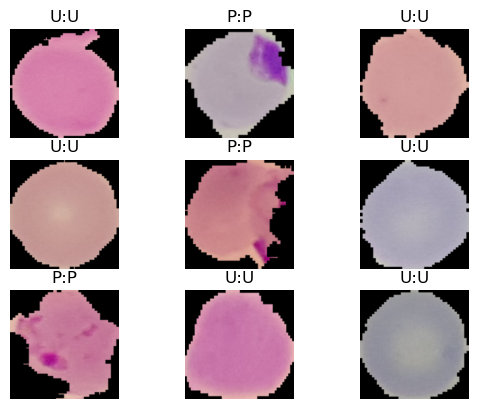

In [53]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))
    
    plt.axis('off')

### Functional API

### Resnet Model